# Augmentator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import Dataset
from visualisation import show_images
from augmentator import Augmentator

## Test augmentation

Original:


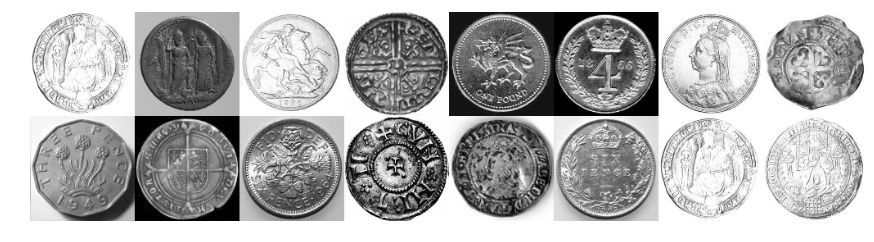

Augmented:


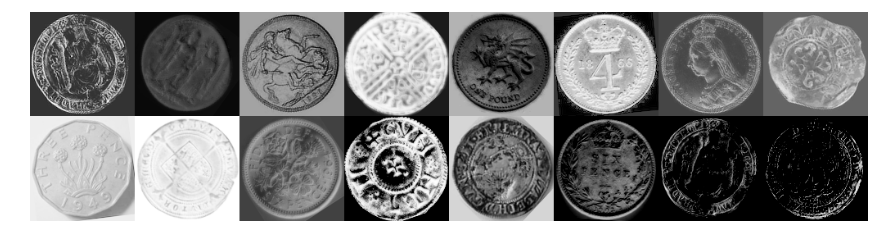

In [2]:
data = Dataset(image_shape=[128, 128, 1])
data.load("/netforge/datasets/private/roman/coins/images", 100)
aug  = Augmentator()

n = 16
idx = np.random.choice(len(data.train_images), n)
im1 = data.train_images[idx]
im2 = aug.augment(im1)

print("Original:")
show_images(im1, data.image_shape, cols=n//2, rows=2)
print("Augmented:")
show_images(im2, data.image_shape, cols=n//2, rows=2)